<a href="https://colab.research.google.com/github/lucascerfig/PyTorch-experiments/blob/master/arxiv_tf_idf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extração de Features
Com o dataset filtrado, limpo e pré-processado, podemos agora iniciar o processo de extração de features do nosso dataset. Esse procedimento irá utilizar por ora um algoritmo simples de vetorização: TF-IDF (Term-Frequency Inverse Document Frequency). Esse algoritmo irá atribuir para cada documento do nosso dataset, um vetor cujos valores referem-se às palavras do vocabulário do dataset baseadas em sua frequência particular em cada documento e também a sua frequência geral nos documentos do dataset.

Dessa forma, conseguimos obter uma representação numérica da cada documento passível de ser computada nos procedimentos seguintes dessa experimentação (como o cálculo de similaridade entre documentos).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

A funcão de vetorização que utilizaremos possui dois parâmetros: o documento a ser vetorizado e o número máximo de features a serem utilizadas para as representações. 

O número máximo de features corresponde à quantidade de palavras do vocabulário que gostaríamos de utilizar no treinamento do algoritmo. Caso um valor x seja atribuído ao argumento max_features, o algoritmo irá levar em consideração apenas as x palavras mais frequentes em seu processamento. 

Isso evita que nossas representações possuam dimensões desnecessárias trazidas por palavras pouco frequentes em nosso dataset.


In [ ]:
def tfidf_vectorizer(text, features):
    vectorizer = TfidfVectorizer(max_features=features)
    X = vectorizer.fit_transform(text)
    return X

In [ ]:
import pandas as pd

# Carregando o dataset preprocessado
docs = pd.read_csv("arxiv_metadata/5000_processed_seed777_arxiv.csv", dtype={'id': str}) 

In [ ]:
# Agora vamos vetorizar a coluna "processed_abstract" do nosso dataframe
# A dimensão das features será 2 ** 12 (4096), limitando o nosso vocabulário para 4096 palavras

text = docs['processed_abstract'].values
X = tfidf_vectorizer(text, 2 ** 12)

In [ ]:
# X agora é uma matriz 5000 (documentos) x 4096 (palavras) resultante do algoritmo TF-IDF
X.shape

(5000, 4096)

## Redução de Dimensionalidade

O vetor representante de cada documento possui 4096 dimensões e pode-se entender que... (**elaborar a respeito da necessidade de redução com TF-IDF**)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=0.95, random_state=777)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(5000, 2255)

## Clustering

Com nossos vetores reduzidos para 2255 dimensões através do PCA, podemos então aplicar um algoritmo de clustering em nossos dados para verificar como está a relação entre os documentos do conjunto.

Iremos utilizar o algoritmo k-means, e para identificar um valor adequado para k, vamos realizar um teste de silhueta. Executaremos o teste com valores **k=2 até k=12**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline



---



In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=777, n_components=2)
X_tsne = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 3.862s...
[t-SNE] Computed neighbors for 5000 samples in 287.118s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.314833
[t-SNE] KL divergence after 50 iterations with early exaggeration: 74.735909
[t-SNE] KL divergence after 1000 iterations: 2.293572


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

For n_clusters = 2 The average silhouette_score is : 0.39183888
For n_clusters = 3 The average silhouette_score is : 0.38613057
For n_clusters = 4 The average silhouette_score is : 0.3673785
For n_clusters = 5 The average silhouette_score is : 0.34904096
For n_clusters = 6 The average silhouette_score is : 0.33662257
For n_clusters = 7 The average silhouette_score is : 0.35338056
For n_clusters = 8 The average silhouette_score is : 0.34608385
For n_clusters = 9 The average silhouette_score is : 0.3426177
For n_clusters = 10 The average silhouette_score is : 0.3532902
For n_clusters = 11 The average silhouette_score is : 0.3525691
For n_clusters = 12 The average silhouette_score is : 0.3465383


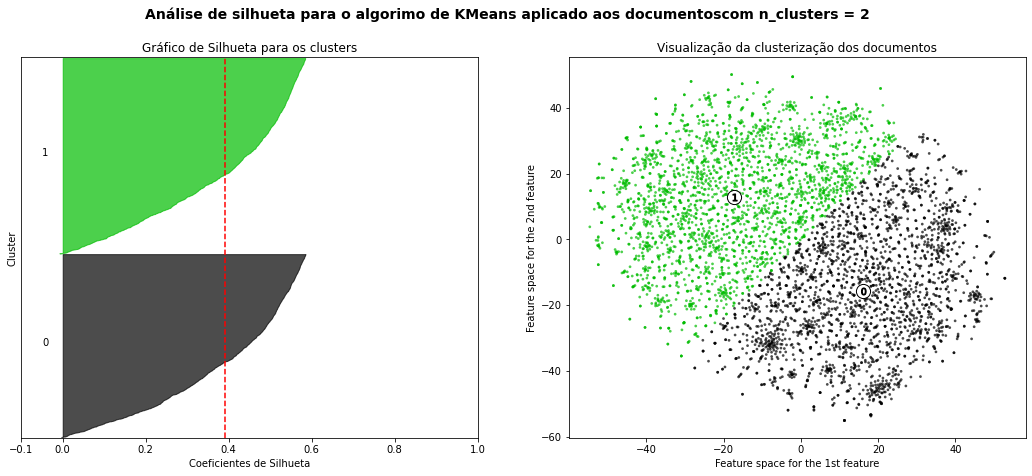

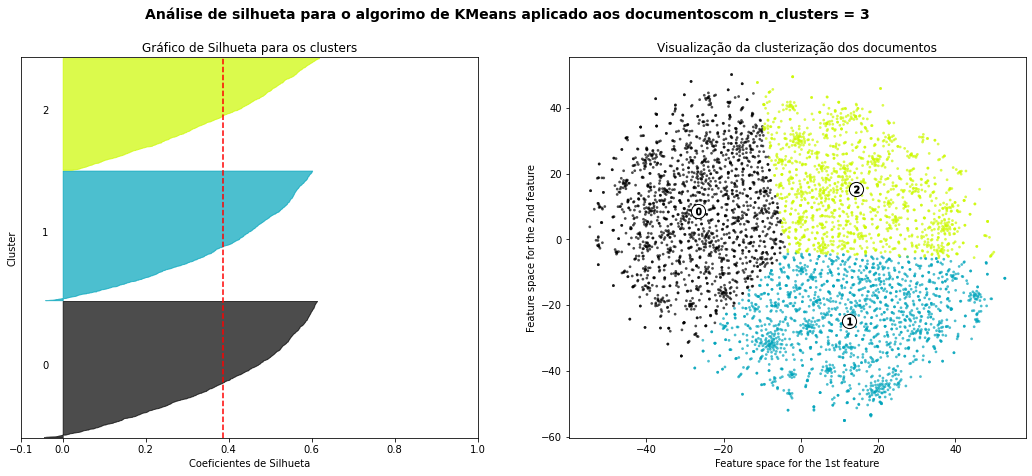

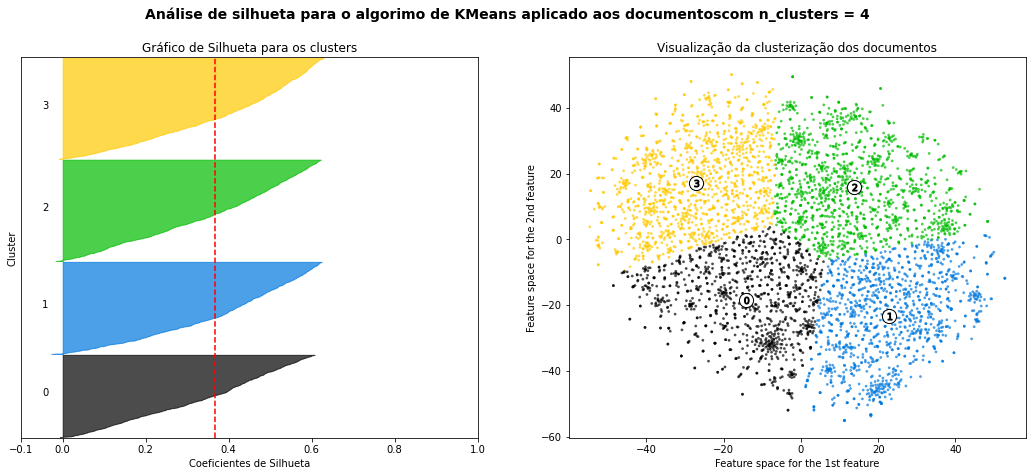

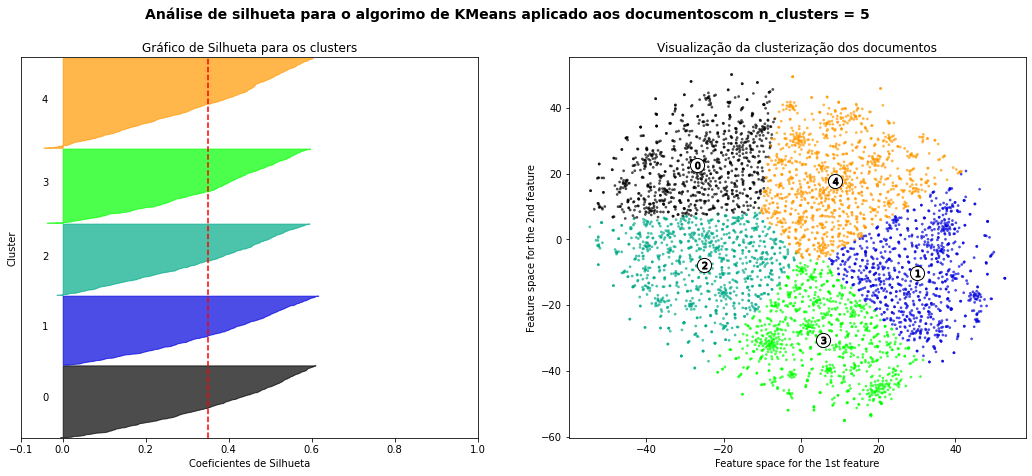

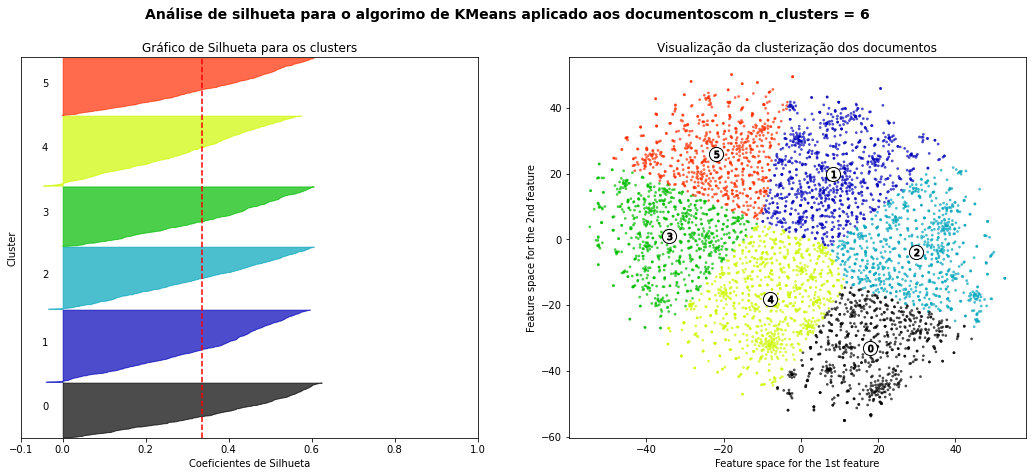

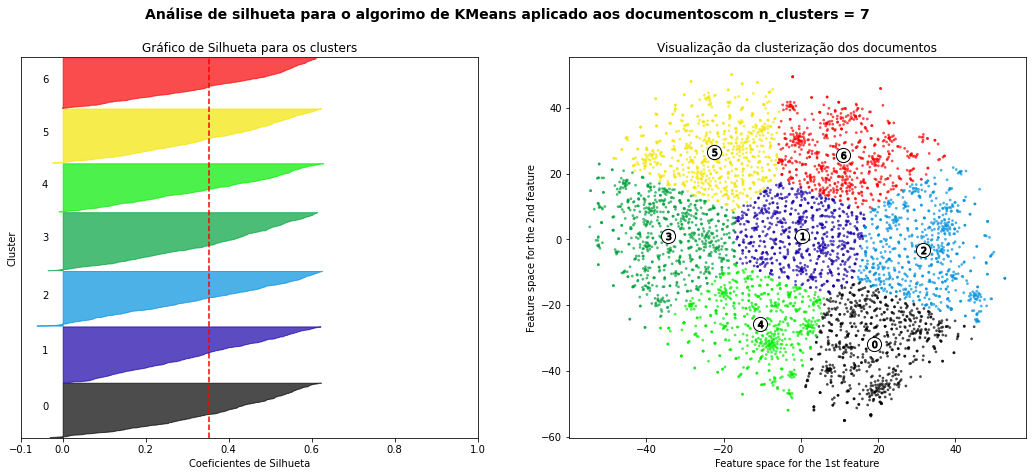

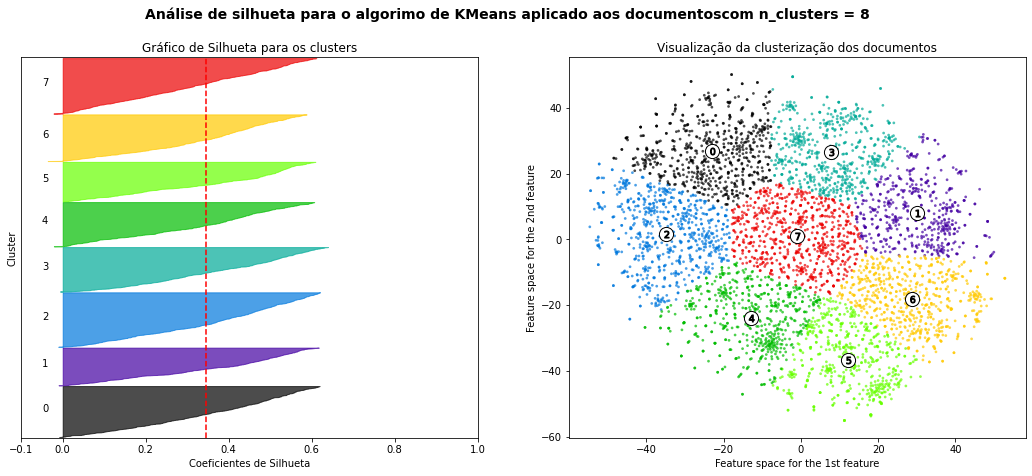

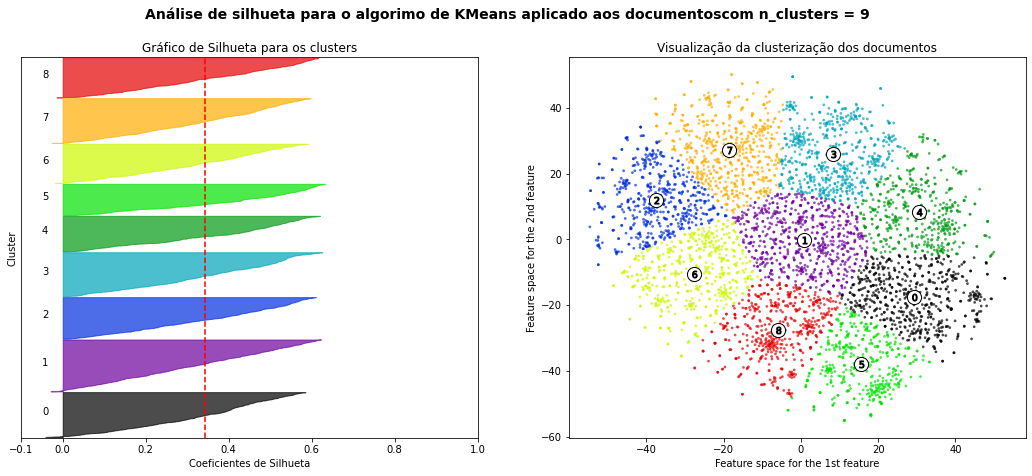

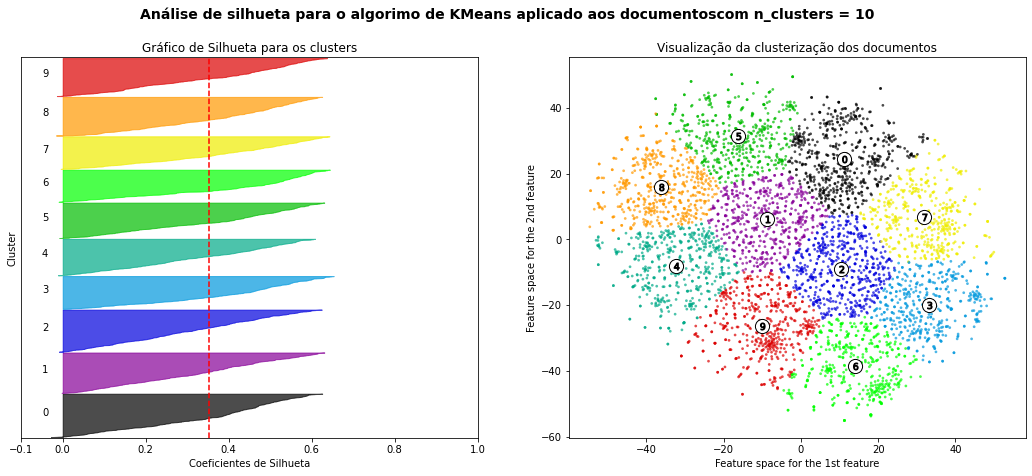

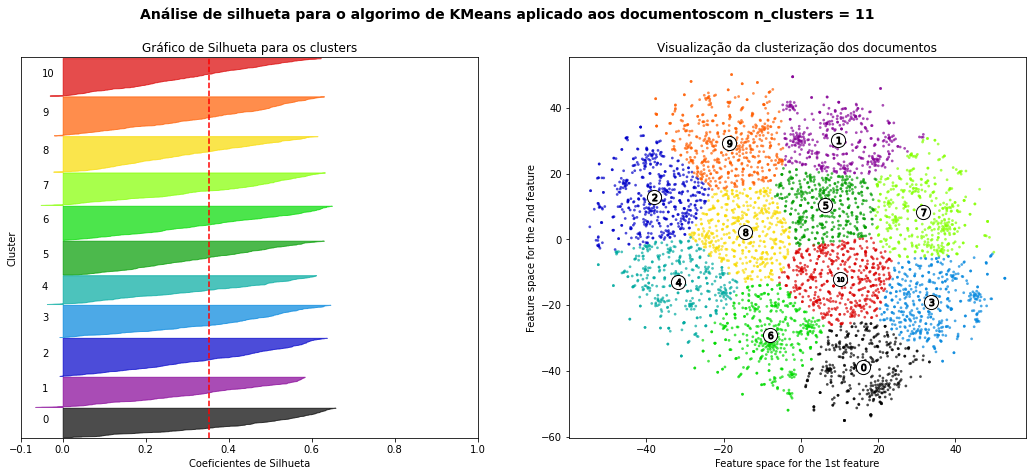

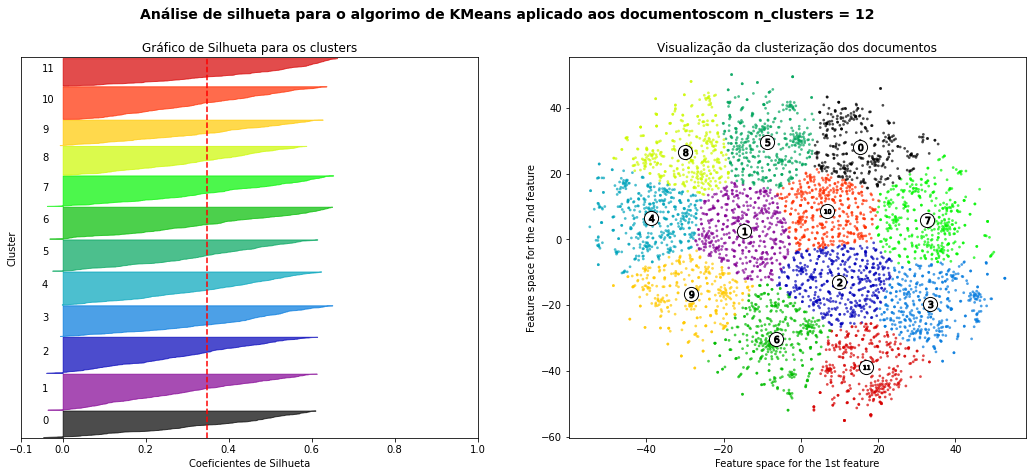

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for n_clusters in range_n_clusters:
    # Criando um subplot com 1 linha e 2 colunas para cada k
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # O primeiro subplot é o plot de silhueta
    # O coeficiente de silhueta pode variar de -1 a 1
    ax1.set_xlim([-0.1, 1])

    # O valor (n_clusters+1)*10 é utilizado para adicionar um espaço entre a silhueta
    # de cada gráfico, demarcando-os com clareza
    ax1.set_ylim([0, len(X_tsne) + (n_clusters + 1) * 10])

    # Inicializando o algoritmo com um um valor para k e uma semente aleatória (777)
    clusterer = KMeans(n_clusters=n_clusters, random_state=777)
    cluster_labels = clusterer.fit_predict(X_tsne)

    # O valor silhouette_score fornece a média do valor para todas as amostras
    # Isso nos dá uma perspectiva melhor da densidade e da separação dos clusters obtidos
    silhouette_avg = silhouette_score(X_tsne, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Computando o score de silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X_tsne, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        # Agregando os scores das amostrar para cada cluster, e ordenando-os
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        

        # Anotando o gráfico com o número do cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Computando o novo valor de y_lower para o próximo gráfico
        y_lower = y_upper + 10  # 10 para as amostras 0

    ax1.set_title("Gráfico de Silhueta para os clusters")
    ax1.set_xlabel("Coeficientes de Silhueta")
    ax1.set_ylabel("Cluster")

    # Adicionando a linha vertical do valor médio do score de silhueta
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Removendo os ticks do eixo y
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2o gráfico mostrando os clusters formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Anotando os clusters
    centers = clusterer.cluster_centers_

    # Desenhando círculos brancos no centro de cada cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualização da clusterização dos documentos")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Análise de silhueta para o algorimo de KMeans aplicado aos documentos"
                  "com n_clusters = %d" % n_clusters),
                fontsize=14, fontweight='bold')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.004159638348680014
For n_clusters = 3 The average silhouette_score is : 0.005091341612286746
For n_clusters = 4 The average silhouette_score is : 0.005280270170422793
For n_clusters = 5 The average silhouette_score is : 0.004873041876880729
For n_clusters = 6 The average silhouette_score is : 0.005995773567004773
For n_clusters = 7 The average silhouette_score is : 0.00620747662498584
For n_clusters = 8 The average silhouette_score is : 0.006476298488032234
For n_clusters = 9 The average silhouette_score is : 0.0065416064628433706
For n_clusters = 10 The average silhouette_score is : 0.007035142451762419
For n_clusters = 11 The average silhouette_score is : 0.0079987101878832
For n_clusters = 12 The average silhouette_score is : 0.008568224155578836


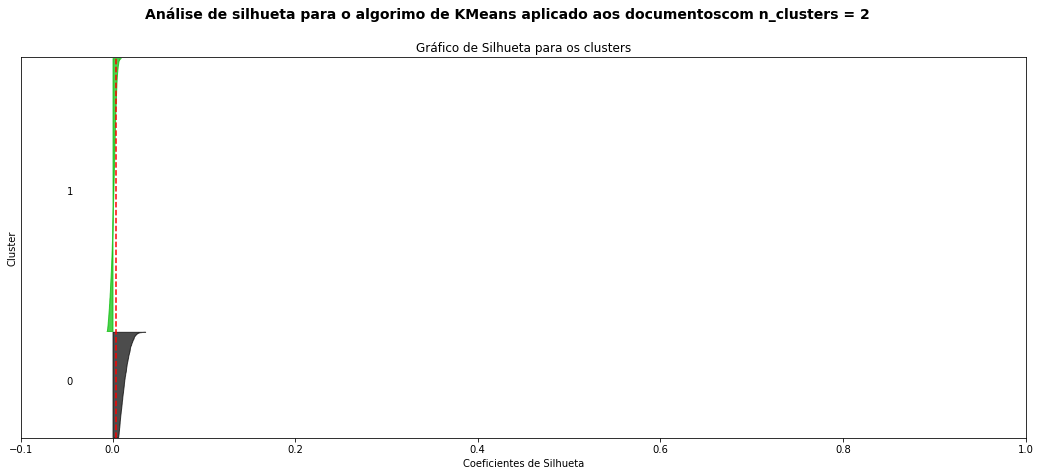

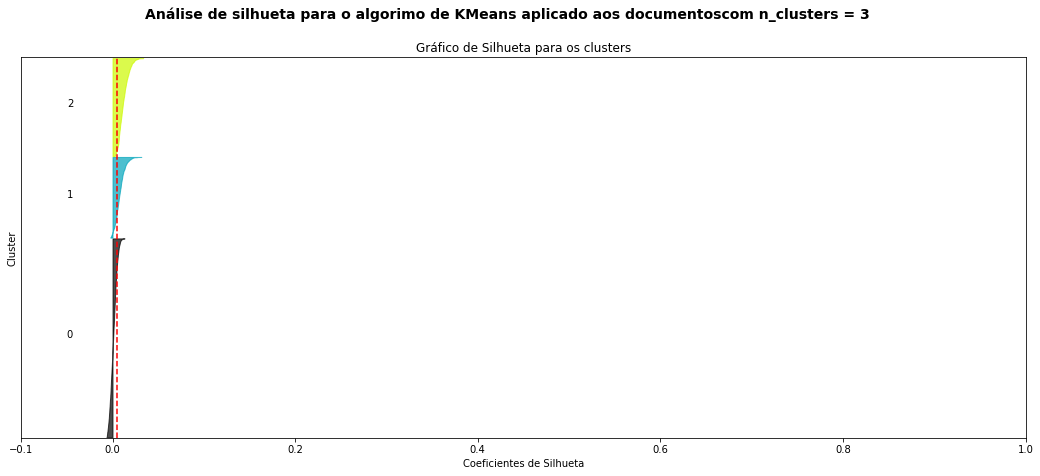

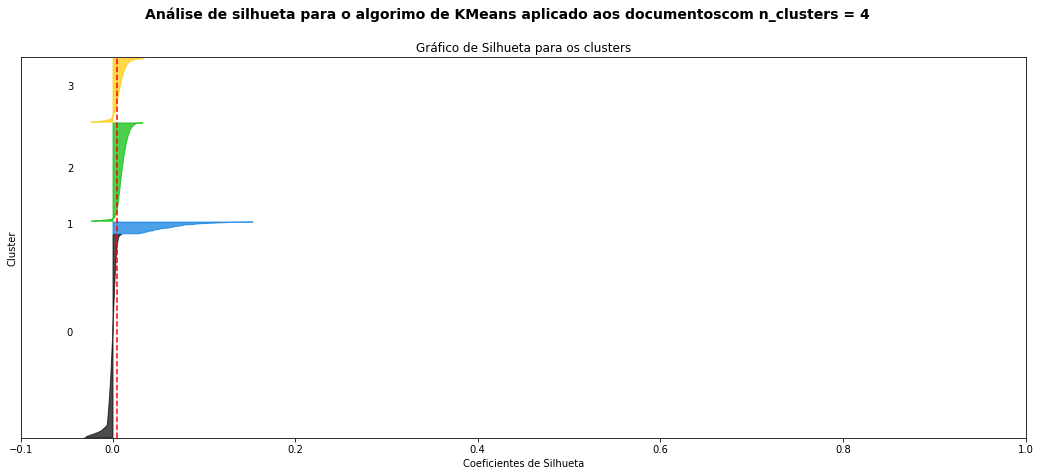

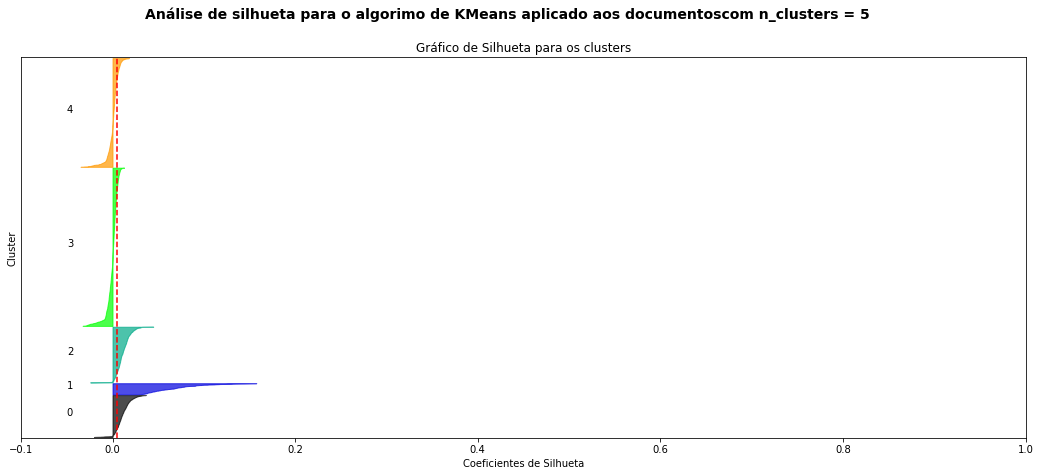

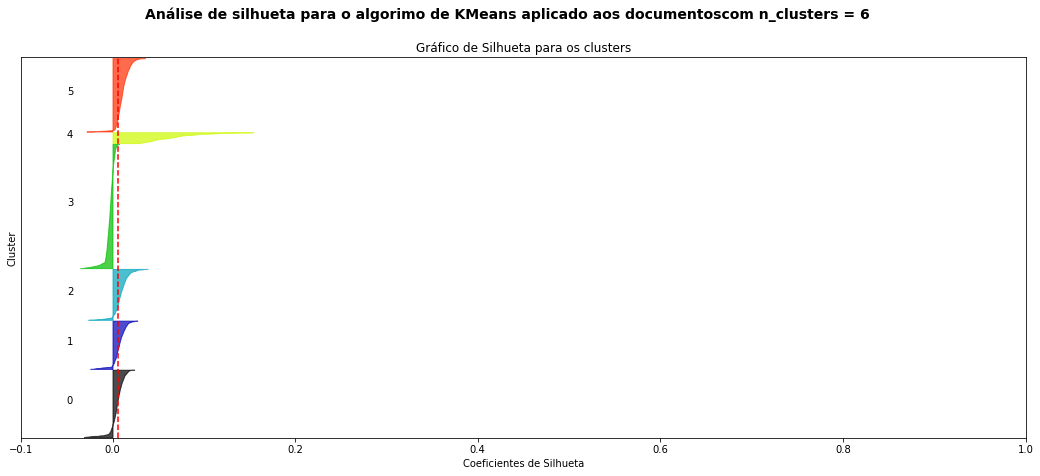

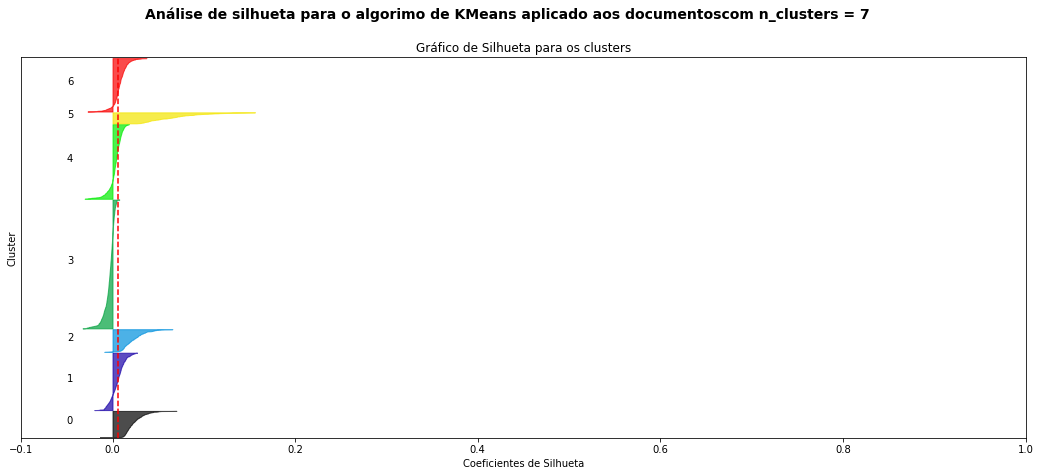

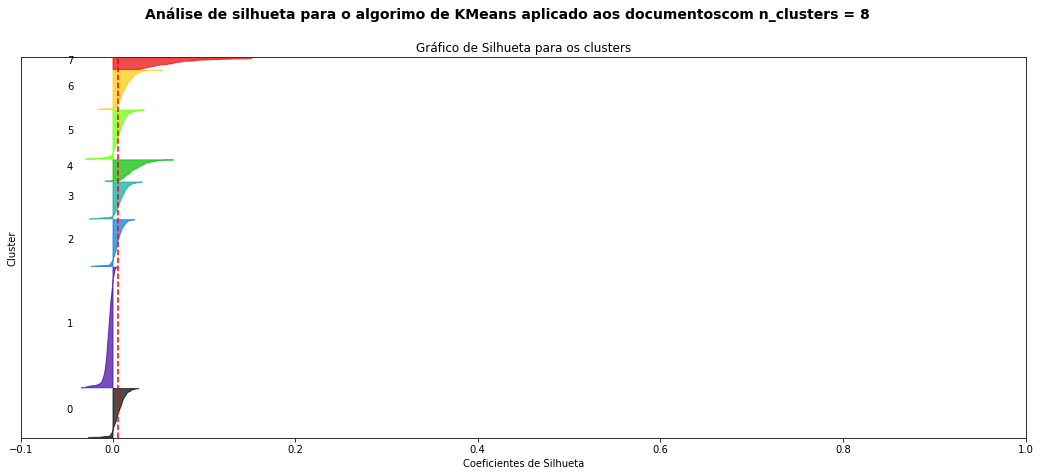

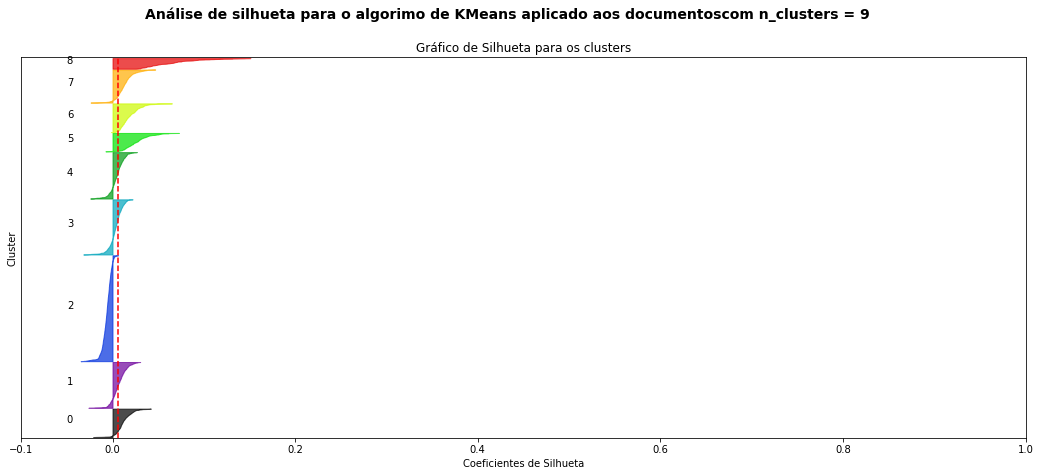

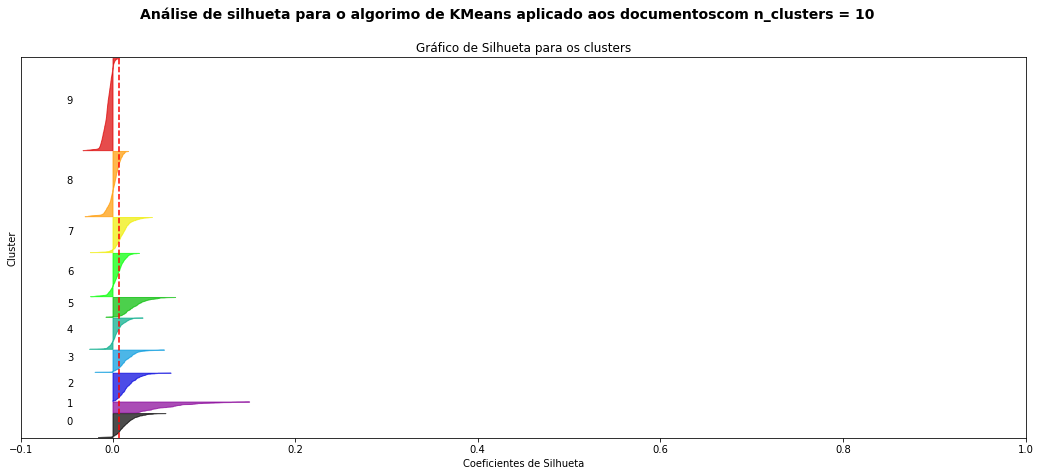

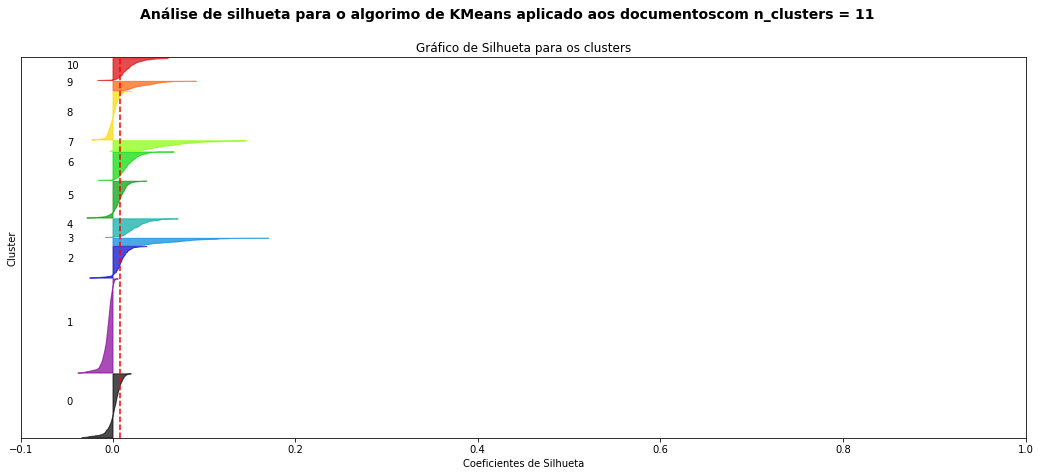

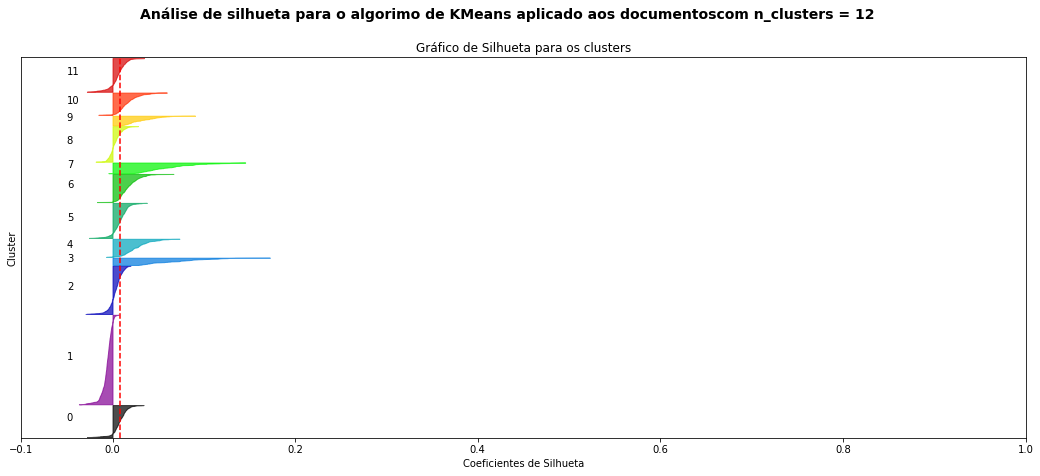

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

X_dense = X.todense()

for n_clusters in range_n_clusters:
    # Criando um subplot com 1 linha e 2 colunas para cada k
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # O primeiro subplot é o plot de silhueta
    # O coeficiente de silhueta pode variar de -1 a 1
    ax1.set_xlim([-0.05, 0.2])

    # O valor (n_clusters+1)*10 é utilizado para adicionar um espaço entre a silhueta
    # de cada gráfico, demarcando-os com clareza
    ax1.set_ylim([0, len(X_dense) + (n_clusters + 1) * 10])

    # Inicializando o algoritmo com um um valor para k e uma semente aleatória (777)
    clusterer = KMeans(n_clusters=n_clusters, random_state=777)
    cluster_labels = clusterer.fit_predict(X_dense)

    # O valor silhouette_score fornece a média do valor para todas as amostras
    # Isso nos dá uma perspectiva melhor da densidade e da separação dos clusters obtidos
    silhouette_avg = silhouette_score(X_dense, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Computando o score de silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X_dense, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        # Agregando os scores das amostrar para cada cluster, e ordenando-os
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        

        # Anotando o gráfico com o número do cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Computando o novo valor de y_lower para o próximo gráfico
        y_lower = y_upper + 10  # 10 para as amostras 0

    ax1.set_title("Gráfico de Silhueta para os clusters")
    ax1.set_xlabel("Coeficientes de Silhueta")
    ax1.set_ylabel("Cluster")

    # Adicionando a linha vertical do valor médio do score de silhueta
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Removendo os ticks do eixo y
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # # 2o gráfico mostrando os clusters formados
    # colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
    #             c=colors, edgecolor='k')

    # # Anotando os clusters
    # centers = clusterer.cluster_centers_

    # # Desenhando círculos brancos no centro de cada cluster
    # ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #             c="white", alpha=1, s=200, edgecolor='k')

    # for i, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                 s=50, edgecolor='k')

    # ax2.set_title("Visualização da clusterização dos documentos")
    # ax2.set_xlabel("Feature space for the 1st feature")
    # ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Análise de silhueta para o algorimo de KMeans aplicado aos documentos"
                  "com n_clusters = %d" % n_clusters),
                fontsize=14, fontweight='bold')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.008568224155578836
For n_clusters = 3 The average silhouette_score is : 0.008568224155578836
For n_clusters = 4 The average silhouette_score is : 0.008568224155578836
For n_clusters = 5 The average silhouette_score is : 0.008568224155578836
For n_clusters = 6 The average silhouette_score is : 0.008568224155578836
For n_clusters = 7 The average silhouette_score is : 0.008568224155578836
For n_clusters = 8 The average silhouette_score is : 0.008568224155578836
For n_clusters = 9 The average silhouette_score is : 0.008568224155578836
For n_clusters = 10 The average silhouette_score is : 0.008568224155578836
For n_clusters = 11 The average silhouette_score is : 0.008568224155578836
For n_clusters = 12 The average silhouette_score is : 0.008568224155578836


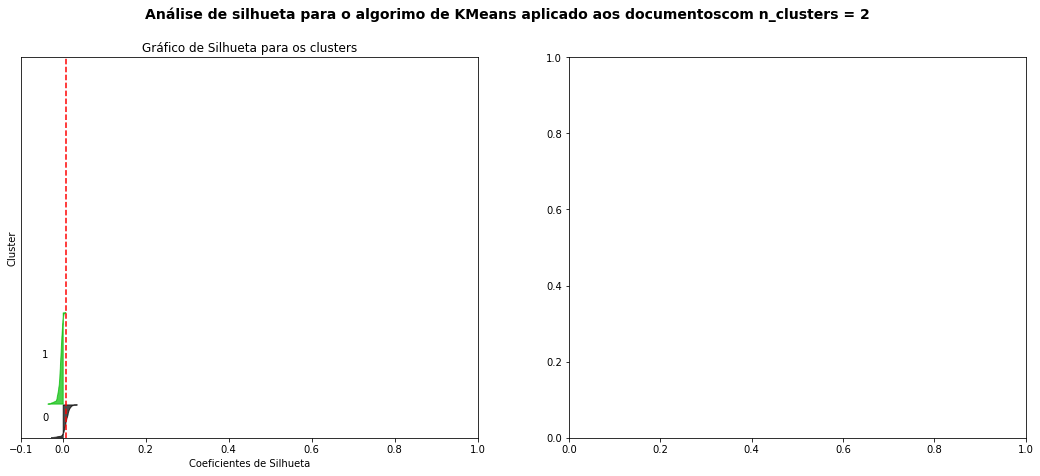

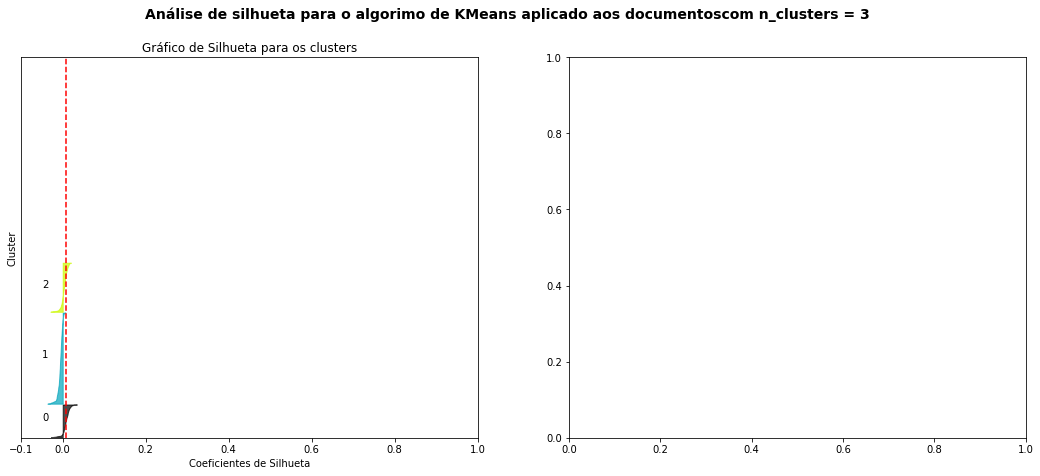

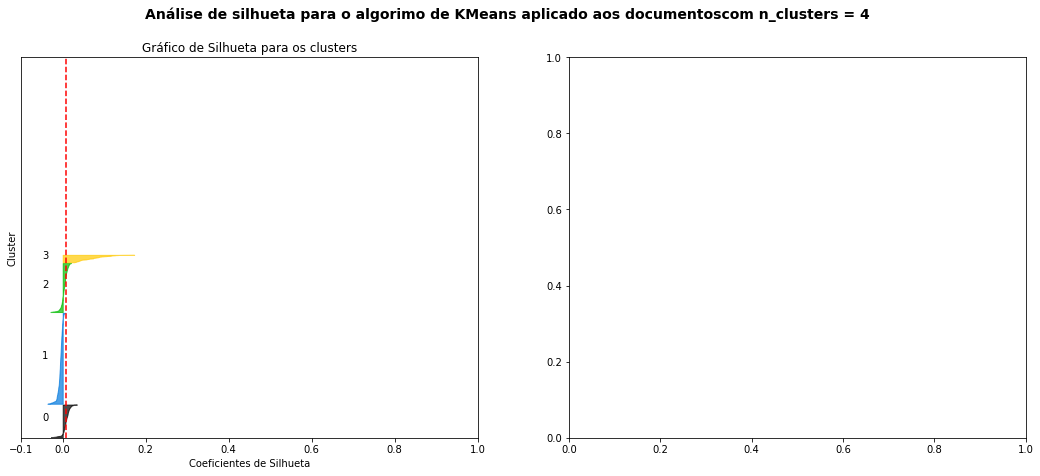

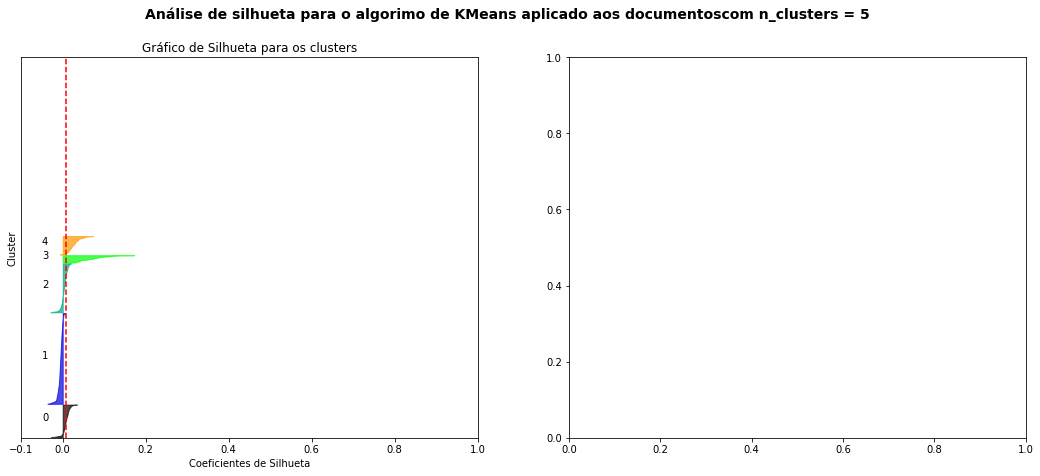

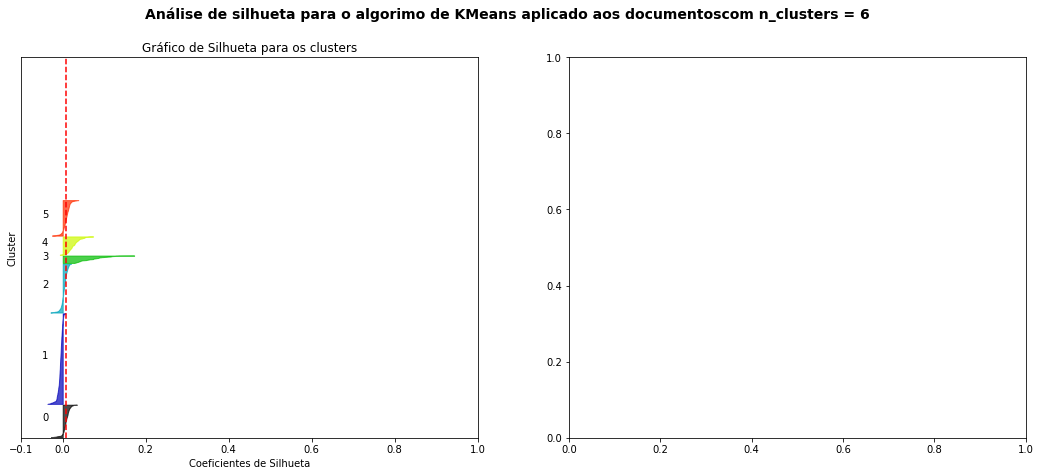

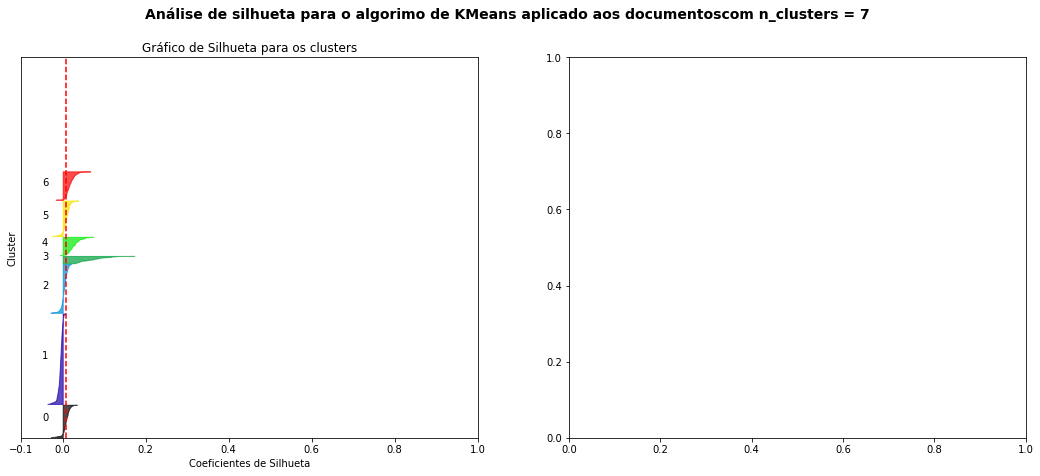

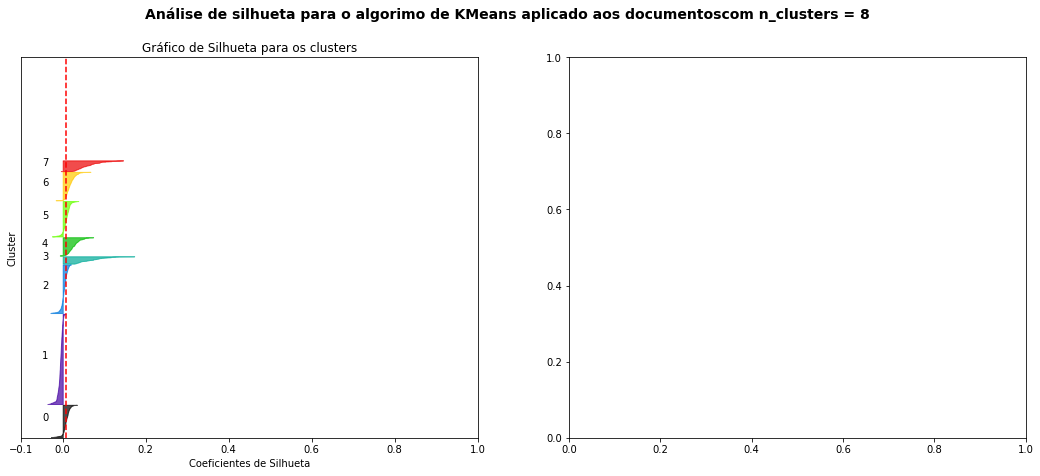

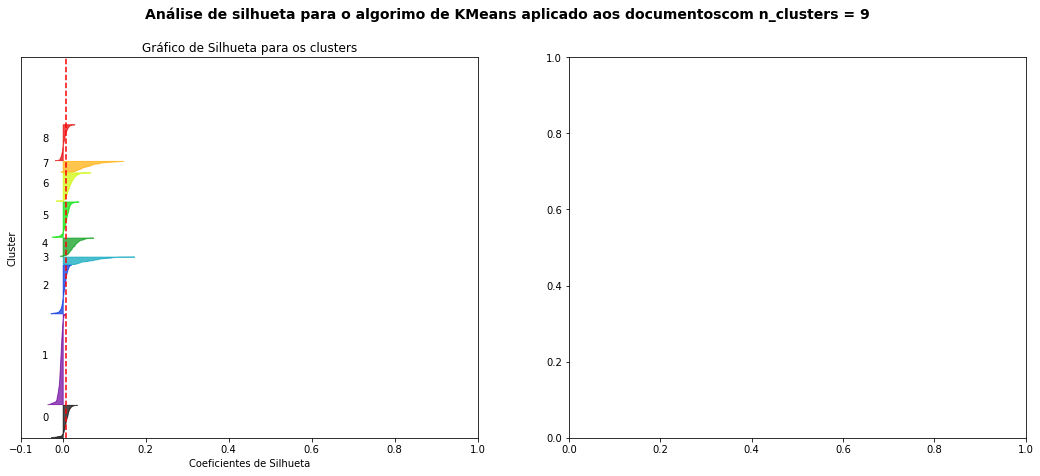

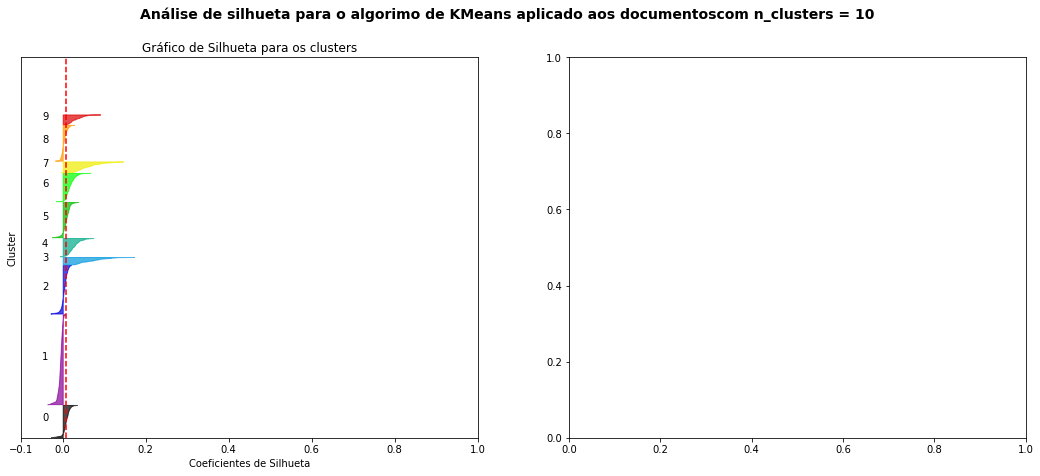

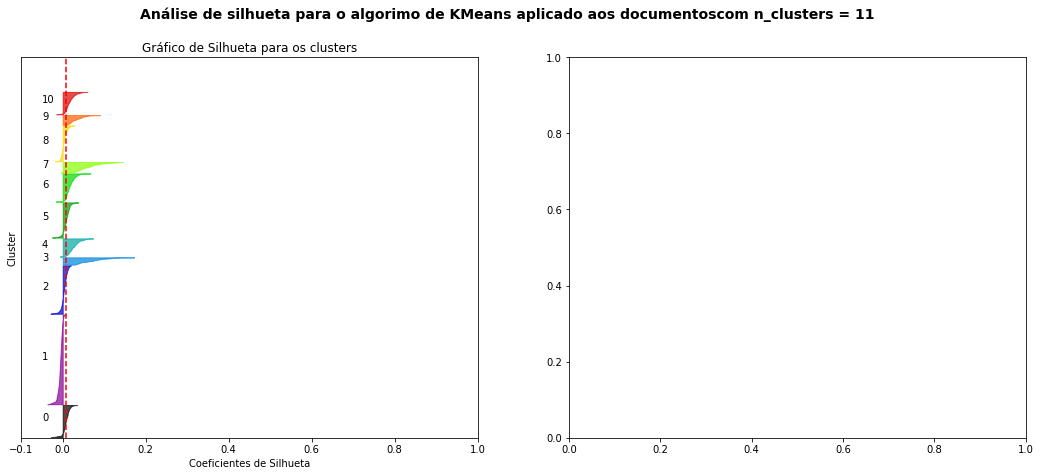

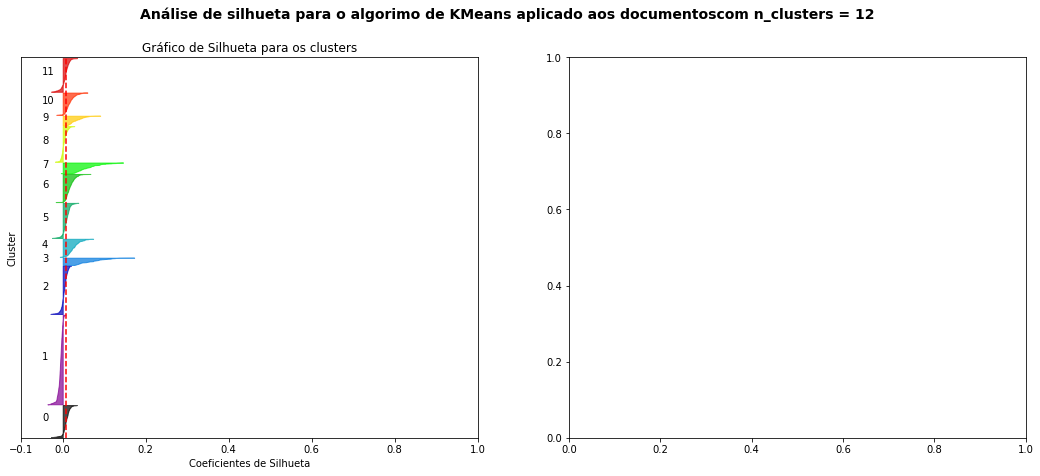

In [ ]:
for n_clusters in range_n_clusters:
    # Criando um subplot com 1 linha e 2 colunas para cada k
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # O primeiro subplot é o plot de silhueta
    # O coeficiente de silhueta pode variar de -1 a 1
    ax1.set_xlim([-0.05, 0.2])

    # O valor (n_clusters+1)*10 é utilizado para adicionar um espaço entre a silhueta
    # de cada gráfico, demarcando-os com clareza
    ax1.set_ylim([0, len(X_dense) + (n_clusters + 1) * 10])

    # Inicializando o algoritmo com um um valor para k e uma semente aleatória (777)
    #clusterer = KMeans(n_clusters=n_clusters, random_state=777)
    #cluster_labels = clusterer.fit_predict(X_dense)

    # O valor silhouette_score fornece a média do valor para todas as amostras
    # Isso nos dá uma perspectiva melhor da densidade e da separação dos clusters obtidos
    silhouette_avg = silhouette_score(X_dense, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Computando o score de silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X_dense, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        # Agregando os scores das amostrar para cada cluster, e ordenando-os
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        

        # Anotando o gráfico com o número do cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Computando o novo valor de y_lower para o próximo gráfico
        y_lower = y_upper + 10  # 10 para as amostras 0

    ax1.set_title("Gráfico de Silhueta para os clusters")
    ax1.set_xlabel("Coeficientes de Silhueta")
    ax1.set_ylabel("Cluster")

    # Adicionando a linha vertical do valor médio do score de silhueta
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Removendo os ticks do eixo y
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # # 2o gráfico mostrando os clusters formados
    # colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
    #             c=colors, edgecolor='k')

    # # Anotando os clusters
    # centers = clusterer.cluster_centers_

    # # Desenhando círculos brancos no centro de cada cluster
    # ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
    #             c="white", alpha=1, s=200, edgecolor='k')

    # for i, c in enumerate(centers):
    #     ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                 s=50, edgecolor='k')

    # ax2.set_title("Visualização da clusterização dos documentos")
    # ax2.set_xlabel("Feature space for the 1st feature")
    # ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Análise de silhueta para o algorimo de KMeans aplicado aos documentos"
                  "com n_clusters = %d" % n_clusters),
                fontsize=14, fontweight='bold')
plt.show()



---



Vamos adicionar uma coluna no dataframe para os clusters com k=5

In [ ]:
k1 = 5
kmeans = KMeans(n_clusters=k1, random_state=777)

y_pred5 = kmeans.fit_predict(X_reduced)
docs['kmean_5'] = y_pred5

E repetiremos o mesmo procedimento para k=10

In [ ]:
k2 = 10
kmeans = KMeans(n_clusters=k2, random_state=777)

y_pred10 = kmeans.fit_predict(X_reduced)
docs['kmean_10'] = y_pred10

In [ ]:
docs[['kmean_5', 'kmean_10']].head()

kmean_5  kmean_10
0        4         8
1        3         9
2        2         4
3        2         6
4        4         1

## Representação Gráfica

Com os documentos já agrupamos, passamos agora ao passo final de visualização do trabalho. Primeiro, precisamos representar os vetores de cada documento em um gráfico bidimensional. Como se tratam de vetores com milhares de dimensões, iremos utilizar outros algoritmos de redução de dimensionalidade, mas focados principalmente em visualização de vetores de grande porte, sendo eles:


*   UMAP
*   T-SNE




In [ ]:
!pip install umap-learn

from umap import UMAP
from sklearn.manifold import TSNE

In [ ]:
umap_embeddings = UMAP(n_neighbors=100, min_dist=0.3, n_components=3)
X_umap = umap_embeddings.fit_transform(X_reduced)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
tsne = TSNE(verbose=1, perplexity=100, random_state=777, n_components=3)
X_tsne = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 4.025s...
[t-SNE] Computed neighbors for 5000 samples in 234.910s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.314833
[t-SNE] KL divergence after 50 iterations with early exaggeration: 74.735909
[t-SNE] KL divergence after 650 iterations: 2.229542


In [ ]:
import plotly.express as px

fig = px.scatter_3d(docs, x=X_tsne[:,0], y=X_tsne[:,1], z=X_tsne[:,2],
                 color=y_pred.astype(str),
                 hover_data=['categories', 'title',],
                 height=1000, width=1000,
                 title= "tsne com labels do kmeans")

fig.show()

In [ ]:
tsne2d = TSNE(verbose=1, perplexity=100, random_state=777, n_components=2)
X_tsne2d = tsne2d.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 3.761s...
[t-SNE] Computed neighbors for 5000 samples in 233.521s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.314833
[t-SNE] KL divergence after 50 iterations with early exaggeration: 74.735909
[t-SNE] KL divergence after 1000 iterations: 2.293572
